In [5]:
!pwd

/home/dongkyu/sDG


In [6]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST, USPS, SVHN, CIFAR10, STL10
from network.modules.identity import Identity

from torch.utils.data import DataLoader

import tensorflow_datasets as tfds

import os
import pickle
import numpy as np
from scipy.io import loadmat
import PIL
from PIL import Image

from tools.autoaugment import SVHNPolicy, CIFAR10Policy
from tools.randaugment import RandAugment


import torchvision.transforms as T
import random

In [7]:
HOME = os.environ['HOME']

# PROF NET


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, RandomSampler
from torchvision import models
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter

import os
import click
import time
import numpy as np
import copy

from loss_functions import SupConLoss, MdarLoss, MdarLossV2
from network import mnist_net, res_net, alex_net, cifar_net, vit_net, reg_net, generator
from network.modules import get_resnet, get_generator, freeze, unfreeze, freeze_, unfreeze_, LARS
from network.modules.batchinstance_norm import BatchInstanceNorm2d
from tools.miro_utils import *
from tools.farmer import *
import data_loader
from main_base import evaluate

import matplotlib.pyplot as plt

In [10]:
encoder = get_resnet('regnet_large', pretrained='True') 
n_features = encoder.fc.in_features
output_dim = 7 
oracle_net= reg_net.ConvNet(encoder, 2048, n_features, output_dim).cuda()
saved_weight = torch.load('saved-model/prof/pacs/base_regnet_large_True_2048_run0/best.pkl')
oracle_net.load_state_dict(saved_weight['cls_net'])
freeze("all",oracle_net)

In [11]:
oracle_net

ConvNet(
  (encoder): RegNet(
    (stem): SimpleStemIN(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (trunk_output): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(528, 528, kernel_size=(3, 3

In [3]:
def load_cifar10(split='train', translate=None, twox=False, ntr=None, autoaug=None, channels=3):
    '''
        autoaug == 'AA', AutoAugment
                   'FastAA', Fast AutoAugment
                   'RA', RandAugment
        channels == 3 return by default rgb 3 channel image
                    1 Return a single channel image
    '''
    path = f'data/cifar10-{split}.pkl'
    cifar10_transforms_train= transforms.Compose([transforms.Resize((32,32))]) #224,224
    if not os.path.exists(path):
        dataset = CIFAR10(f'{HOME}/.pytorch/CIFAR10', train=(split=='train'), download=True, transform= cifar10_transforms_train)
        x, y = dataset.data, dataset.targets
        
        #Only Select First 10k images as train
        #if split=='train':
        #    x, y = x[0:10000], y[0:10000]
        
        #[TODO] - solve -> AttributeError: 'numpy.ndarray' object has no attribute 'numpy'
        #x = torch.tensor(resize_imgs(x.numpy(), 32))
        #x = torch.tensor(resize_imgs_dkcho(x, 32)) # x-> torch.Size([10000, 32, 32, 3])
        x= torch.tensor(x)
        x = (x.float()/255.)#.unsqueeze(1).repeat(1,3,1,1)  #<class 'torch.Tensor'>
        x= x.permute(0,3,1,2) #[batchsize,w,h,channel] -> [batchsize, channel, w,h]
        y = torch.tensor(y)
        with open(path, 'wb') as f:
            pickle.dump([x, y], f)
    with open(path, 'rb') as f:
        x, y = pickle.load(f)
        if channels == 1:
            x = x[:,0:1,:,:]
    
    if ntr is not None:
        x, y = x[0:ntr], y[0:ntr]
    
    # Without Data Augmentation
    if (translate is None) and (autoaug is None):
        dataset = TensorDataset(x, y)
        return dataset
    
    # Data Augmentation Pipeline
    transform = [transforms.ToPILImage()]
    if translate is not None:
        transform.append(transforms.RandomAffine(0, [translate, translate]))
    if autoaug is not None:
        if autoaug == 'AA':
            transform.append(CIFAR10Policy()) #originally SVHNPolicy()
        elif autoaug == 'RA':
            transform.append(RandAugment(3,4))
    transform.append(transforms.ToTensor())
    transform = transforms.Compose(transform)
    dataset = myTensorDataset(x, y, transform=transform, twox=twox)
    return dataset




def load_usps(split='train', channels=3):
    path = f'data/usps-{split}.pkl'
    if not os.path.exists(path):
        dataset = USPS(f'{HOME}/.pytorch/USPS', train=(split=='train'), download=True)
        x, y = dataset.data, dataset.targets
        x = torch.tensor(resize_imgs(x, 32))
        x = (x.float()/255.).unsqueeze(1).repeat(1,3,1,1)
        y = torch.tensor(y)
        with open(path, 'wb') as f:
            pickle.dump([x, y], f)
    with open(path, 'rb') as f:
        x, y = pickle.load(f)
        if channels == 1:
            x = x[:,0:1,:,:]
    dataset = TensorDataset(x, y)
    return dataset

In [4]:
def load_cifar10c(split='train', translate=None, twox=False, ntr=None, autoaug=None, channels=3):
    path = f'data/cifar10c-{split}.pkl'
    cifar10_transforms_train= transforms.Compose([transforms.Resize((32,32))]) #224,224
    if not os.path.exists(path):
        dataset = tfds.as_numpy(tfds.load('cifar10_corrupted', split= split, shuffle_files= True, batch_size= -1))
        x, y = dataset['image'], dataset['label']
        x= torch.tensor(x)
        x = (x.float()/255.)#.unsqueeze(1).repeat(1,3,1,1)  #<class 'torch.Tensor'>
        x= x.permute(0,3,1,2) #[batchsize,w,h,channel] -> [batchsize, channel, w,h]
        y = torch.tensor(y)
        with open(path, 'wb') as f:
            pickle.dump([x, y], f)
    with open(path, 'rb') as f:
        x, y = pickle.load(f)
        if channels == 1:
            x = x[:,0:1,:,:]
    
    if ntr is not None:
        x, y = x[0:ntr], y[0:ntr]
    
    # Without Data Augmentation
    if (translate is None) and (autoaug is None):
        dataset = TensorDataset(x, y)
        return dataset

In [5]:
conv={0:"airplane",
1:"automobile",
2:"bird",
3:"cat",
4:"deer",
5:"dog",
6:"frog",
7:"horse",
8:"ship",
9:"truck"}

In [6]:
cifar10_transforms_train = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = CIFAR10(f'{HOME}/.pytorch/CIFAR10', train='train', download=True, transform= cifar10_transforms_train)#cifar10_transforms_train)


Files already downloaded and verified


In [7]:
x, y = dataset.data, dataset.targets


In [8]:
x= torch.tensor(x)
y = torch.tensor(y)

In [9]:
x= x.float()
#x= (x.float()/255.)
x= x.permute(0,3,1,2) #[batchsize,w,h,channel] -> [batchsize, channel, w,h]

#x= transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(x)

In [10]:
dataset= TensorDataset(x,y)

In [11]:
train_loader = torch.utils.data.DataLoader(dataset,batch_size=128,drop_last=True, shuffle=True)
x, y= next(iter(train_loader))

i= 77
sample= x[i]
samplelabel= y[i]



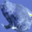

In [12]:
#x= x.permute(0,2,3,1)

# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()

# convert the tensor to PIL image using above transform
img = transform(sample)

# display the PIL image
img.show()

display(img)

In [13]:
from collections import Counter
Counter(y.tolist())


Counter({1: 11, 5: 11, 7: 13, 3: 15, 8: 13, 0: 9, 9: 14, 2: 16, 4: 10, 6: 16})

# CIFAR10c

In [25]:
ds= tfds.load('cifar10_corrupted/impulse_noise_5', split= 'test', shuffle_files= False, batch_size= -1)

In [23]:
train_loader= DataLoader(ds, batch_size=10, num_workers=8)

In [24]:
x, y= next(iter(train_loader))

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/anaconda3/envs/simclr/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/anaconda3/envs/simclr/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/anaconda3/envs/simclr/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
KeyError: 0


# MNIST-M

In [11]:
dataset= load_mnist_m('test')

# SVHN

In [ ]:
dataset= load_svhn('test')

Using downloaded and verified file: /home/dongkyu/.pytorch/SVHN/test_32x32.mat


# PACS

In [15]:
dataset= load_pacs(split='photo')
train_size= len(dataset)
train_loader = torch.utils.data.DataLoader(dataset,batch_size=train_size,drop_last=True, shuffle=True)

x, y= next(iter(train_loader))

In [17]:
len(dataset)

1670

In [145]:
y= y.tolist()
from collections import Counter
c=Counter(y)
print(c)

Counter({4: 816, 0: 772, 2: 753, 1: 740, 3: 608, 6: 160, 5: 80})


In [146]:
sample,samplelabel= x[0],y[0]

In [147]:
samplelabel

5

In [148]:
topil= transforms.ToPILImage()
image= topil(sample)
image.save('./data/image_test.png')

# Check STL10

In [189]:
def load_stl10(split='train', channels=3):
    STL10_transforms_train= transforms.Compose([transforms.Resize((32,32))])
    dataset = STL10(f'{HOME}/.pytorch/STL10', split=split, download=True, transform= STL10_transforms_train)
    x, y = dataset.data, dataset.labels
    x = x.astype('float32')/255.
    x, y = torch.tensor(x), torch.tensor(y)
    if channels == 1:
        x = x.mean(1, keepdim=True)
    dataset = TensorDataset(x, y)
    return dataset

In [190]:
dataset= load_stl10('train')
train_loader = torch.utils.data.DataLoader(dataset,batch_size=1,drop_last=True)
x, y= next(iter(train_loader))
x= x[-1]

Files already downloaded and verified


In [192]:
topil= transforms.ToPILImage()
image= topil(x)
image.save('image_test.png')

# Check CIFAR10

In [196]:
dataset= load_cifar10('train')
train_loader = torch.utils.data.DataLoader(dataset,batch_size=2,drop_last=True)
x, y= next(iter(train_loader))
x= x[-1]

In [197]:
topil= transforms.ToPILImage()
image= topil(x)
image.save('./data/image_test.png')

# Wide Resnet

In [1]:
import torchvision


/opt/anaconda3/envs/simclr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model= torchvision.models.regnet_y_16gf(weights= None)

In [3]:
model= torchvision.models.regnet_y_128gf(weights= None)

In [4]:
model

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [50]:
model.fc

Linear(in_features=7392, out_features=1000, bias=True)

In [38]:
model.classifier= model.classifier[:2]

In [40]:
model.classifier[-1]= Identity()

In [41]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Identity()
  )
)

# Con_LOSS

In [12]:
a= torch.randn(128,128)
b = torch.randn(128,128)
c = torch.randn(128,128)
d = torch.randn(128,128)
features= [a,b,c,d]

In [15]:
batch_size= 128

In [16]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

In [17]:
total_loss= 0.0
for p, anchor_feature in enumerate(features):
    for q, contrast_feature in enumerate(features):
        if p != q:
            anchor_feature= (anchor_feature - anchor_feature.mean(0)) / anchor_feature.std(0) #torch.Size([256, 128])
            contrast_feature = (contrast_feature - contrast_feature.mean(0)) / contrast_feature.std(0) #torch.Size([256, 128])
            c= torch.matmul(anchor_feature.T, contrast_feature) 
            c.div_(batch_size)
            on_diag = torch.diagonal(c).add_(-1).pow_(2).sum() # appr. 2~3
            off_diag = off_diagonal(c).pow_(2).sum()
                        
            loss = on_diag + 0.0051 * off_diag
            print("{a}--{b} LOSS: {c}".format(a=p,b=q,c= loss))
            total_loss += loss

0--1 LOSS: 130.9720458984375
0--2 LOSS: 130.98446655273438
0--3 LOSS: 129.42559814453125
1--0 LOSS: 130.9720458984375
1--2 LOSS: 129.5026397705078
1--3 LOSS: 128.0531768798828
2--0 LOSS: 130.98446655273438
2--1 LOSS: 129.5026397705078
2--3 LOSS: 130.7725067138672
3--0 LOSS: 129.42559814453125
3--1 LOSS: 128.0531768798828
3--2 LOSS: 130.7725067138672


In [146]:
import itertools

In [154]:
53.4333 * 6

320.5998

In [155]:
26.2334 * 12

314.8008

In [152]:
a= list(itertools.combinations(list(range(len(features))), 2))
if (1,2) in a:
    print("Yes")

Yes


In [158]:
len(a)

6

In [145]:
torch.combinations(torch.tensor([1,2,3]))

tensor([[1, 2],
        [1, 3],
        [2, 3]])

In [54]:
torch.unbind(features, dim=1)[1].shape

torch.Size([128, 128])

In [44]:
contrast_count = features.shape[1]
contrast_feature= torch.cat(torch.unbind(features, dim=1), dim=0)

In [55]:
contrast_feature

tensor([[0.7332, 0.0929, 0.2580,  ..., 0.3973, 0.9955, 0.8535],
        [0.0841, 0.8132, 0.7651,  ..., 0.0038, 0.9857, 0.8988],
        [0.0678, 0.3891, 0.4295,  ..., 0.6152, 0.9006, 0.6406],
        ...,
        [0.4338, 0.5726, 0.2865,  ..., 0.3523, 0.1264, 0.3898],
        [0.1844, 0.9726, 0.0948,  ..., 0.2757, 0.4321, 0.1781],
        [0.0125, 0.1082, 0.3442,  ..., 0.6851, 0.8039, 0.7882]])

In [46]:
anchor_feature = features[:, 0]

In [11]:
anchor_feature = contrast_feature
anchor_count = contrast_count

In [13]:
anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            0.07)

In [14]:
anchor_dot_contrast

tensor([[596.3107, 452.5212, 462.6601,  ..., 410.0806, 430.4772, 447.1158],
        [452.5212, 615.8022, 454.5374,  ..., 439.8339, 446.4165, 479.2466],
        [462.6601, 454.5374, 627.1229,  ..., 443.9037, 501.7697, 459.4048],
        ...,
        [410.0806, 439.8339, 443.9037,  ..., 558.7839, 472.4926, 447.3414],
        [430.4772, 446.4165, 501.7697,  ..., 472.4926, 632.8708, 477.7922],
        [447.1158, 479.2466, 459.4048,  ..., 447.3414, 477.7922, 637.1094]])

In [15]:
logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)

In [17]:
logits= anchor_dot_contrast- logits_max.detach()

In [19]:
logits.shape

torch.Size([256, 256])

In [26]:
mask= mask.repeat(anchor_count, contrast_count)

In [30]:
logits_mask = torch.scatter(torch.ones_like(mask), 1, torch.arange(batch_size*anchor_count).view(-1,1),0)

In [31]:
logits_mask

tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 0.]])

In [32]:
mask= mask*logits_mask

In [34]:
exp_logits = torch.exp(logits) * logits_mask

In [36]:
log_prob = torch.log( 1- exp_logits / (exp_logits.sum(1, keepdim=True)+1e-6) - 1e-6)

In [37]:
log_prob

tensor([[-1.0133e-06, -1.0133e-06, -1.0133e-06,  ..., -1.0133e-06,
         -1.0133e-06, -1.0133e-06],
        [-1.0133e-06, -1.0133e-06, -1.0133e-06,  ..., -1.0133e-06,
         -1.0133e-06, -1.0133e-06],
        [-1.0133e-06, -1.0133e-06, -1.0133e-06,  ..., -1.0133e-06,
         -1.0133e-06, -1.0133e-06],
        ...,
        [-1.0133e-06, -1.0133e-06, -1.0133e-06,  ..., -1.0133e-06,
         -1.0133e-06, -1.0133e-06],
        [-1.0133e-06, -1.0133e-06, -1.0133e-06,  ..., -1.0133e-06,
         -1.0133e-06, -1.0133e-06],
        [-1.0133e-06, -1.0133e-06, -1.0133e-06,  ..., -1.0133e-06,
         -1.0133e-06, -1.0133e-06]])